In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_and_process_flat(file_name : str,
                          base_path,
                          layer_name : str = "layer_40"):
    data = np.load(f"{base_path}/heatmap/{file_name}")
    heatmaps = data[layer_name]
    heatmaps = np.abs(heatmaps)
    heatmaps_flat = heatmaps.reshape(heatmaps.shape[0], -1)
    return heatmaps, heatmaps_flat

In [76]:
def visualize_clusters(clusters_analysis_file_base_name: str,
                       base_path: str,
                       target_occurence_min_per_class: dict,
                       list_image_name_to_test: list):
    all_feature_in_each_class = np.load(f"{base_path}/clusters_analysis/{clusters_analysis_file_base_name}_{SUFFIX_ALL_FEATURE_IN_EACH_CLASS}.npz")
    class_and_occurence_per_feature = np.load(f"{base_path}/clusters_analysis/{clusters_analysis_file_base_name}_{SUFFIX_CLASS_AND_OCCURENCE_PER_FEATURE}.npz")

    dict_feature_per_class = {}
    for key in all_feature_in_each_class.keys():
        if key not in target_occurence_min_per_class.keys():
            dict_feature_per_class[key] = all_feature_in_each_class[key]
            print(f"Key {key} not found in target_occurence_min_per_class. Getting all features of all_feature_in_each_class for this key.")
            continue
        dict_feature_per_class[key] = []
        for feature in all_feature_in_each_class[key]:
            min_occurence_for_this_class = target_occurence_min_per_class[key]
            if class_and_occurence_per_feature[str(feature)][1] >= min_occurence_for_this_class:
                dict_feature_per_class[key].append(feature)

    vmin, vmax = float("inf"), float("-inf")
    heatmap_per_class_per_image = {}
    for key in dict_feature_per_class.keys():
        heatmap_per_image = {}
        for image_name in list_image_name_to_test:
            heatmap_file_name = f"{image_name}.npz"
            heatmaps, _ = load_and_process_flat(heatmap_file_name, base_path, layer_name="layer_40")
            feature_index = np.array(dict_feature_per_class[key])
            if len(feature_index) == 0:
                print(f"No feature found for {key} in {image_name}")
                continue

            cluster_heatmaps = heatmaps[feature_index]
            combined_heatmap = np.sum(cluster_heatmaps, axis=0)
            vmin = min(vmin, combined_heatmap.min())
            vmax = max(vmax, combined_heatmap.max())
            heatmap_per_image[image_name] = combined_heatmap
        heatmap_per_class_per_image[key] = heatmap_per_image

    nb_line_adjust = sum(len(heatmap_per_class_per_image[key]) > 0 for key in heatmap_per_class_per_image)
    nb_col_adjust = max((len(heatmap_per_class_per_image[key]) for key in heatmap_per_class_per_image), default=0)

    fig, axes = plt.subplots(nrows=nb_line_adjust, ncols=nb_col_adjust, figsize=(4 * nb_col_adjust, 4 * nb_line_adjust))
    fig.tight_layout(pad=3.0)

    if nb_line_adjust == 1 and nb_col_adjust == 1:
        axes = np.array([[axes]])
    elif nb_line_adjust == 1:
        axes = axes.reshape(1, -1)
    elif nb_col_adjust == 1:
        axes = axes.reshape(-1, 1)

    for row_idx, (class_name, heatmap_per_image) in enumerate(heatmap_per_class_per_image.items()):
        if not heatmap_per_image:
            print(f"No image found for {class_name}")
            continue
        for col_idx, image_name in enumerate(list_image_name_to_test):
            ax = axes[row_idx, col_idx]
            heatmap = heatmap_per_image.get(image_name)
            if heatmap is not None:
                im = ax.imshow(heatmap, cmap='viridis', vmin=vmin, vmax=vmax)
                ax.set_title(f"{class_name} - {image_name}", fontsize=10)
            else:
                ax.axis('off')
            ax.axis('off')

    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.05, pad=0.02)
    cbar.set_label('Activation Intensity')

    plt.show()

TODO : put file name in key and in values a tuple with min and max born and cluster method to display

In [50]:
base_path = "./data/v6/clusters"

In [51]:
SUFFIX_NB_LEVEL_OCCURENCE_PER_CLASS = "nb_level_occurence_per_class"
SUFFIX_CLASS_AND_OCCURENCE_PER_FEATURE = "class_and_occurence_per_feature"
SUFFIX_ALL_FEATURE_IN_EACH_CLASS = "all_feature_in_each_class"

In [52]:
CLUSTER_FEATURE_NONE = "None"
CLUSTER_FEATURE_EYE = "Eye"
CLUSTER_FEATURE_HEAD = "Head"
CLUSTER_FEATURE_BODY = "Body"
CLUSTER_FEATURE_BEAK = "Beak"
CLUSTER_FEATURE_WING = "Wing"
CLUSTER_FEATURE_TAIL = "Tail"
CLUSTER_FEATURE_LEG = "Leg"

Modifie pour mettre le nom sans .npz des images sur lesquelles tu veux tester les différents clusters comme eye, tail etc...

In [53]:
list_image_name_to_test = [
    'n01829413_5429',
    'n01829413_46',
]

Modifie pour mettre le nom sous lequel dans cluster_v6_analysis_v2 tu as sauvegardé

In [54]:
cluster_analysis_file_to_use = "t1"

In [55]:
with open(f"{base_path}/imagenet_class_index_reversed.json", "r") as file:
    dictionary_class_index = json.load(file)

Modifie pour mettre les bon trucs que tu veux afficher. Mais à 0 l'ensemble des cluster si tu t'en fou

In [56]:
target_occurence_min_per_class = {
    CLUSTER_FEATURE_TAIL: 1, #minimum 10 occurence pour garder la feature dans le cluster Tail lors de l'affichage
    CLUSTER_FEATURE_WING: 1,
    CLUSTER_FEATURE_BEAK: 1,
    CLUSTER_FEATURE_BODY: 1,
    CLUSTER_FEATURE_HEAD: 1,
    CLUSTER_FEATURE_EYE: 1,
    CLUSTER_FEATURE_LEG: 1,
}

Key None not found in target_occurence_min_per_class. Getting all features of all_feature_in_each_class for this key.
No feature found for Tail in n01829413_5429
No feature found for Tail in n01829413_46
No feature found for Leg in n01829413_5429
No feature found for Leg in n01829413_46
No image found for Tail
No image found for Leg


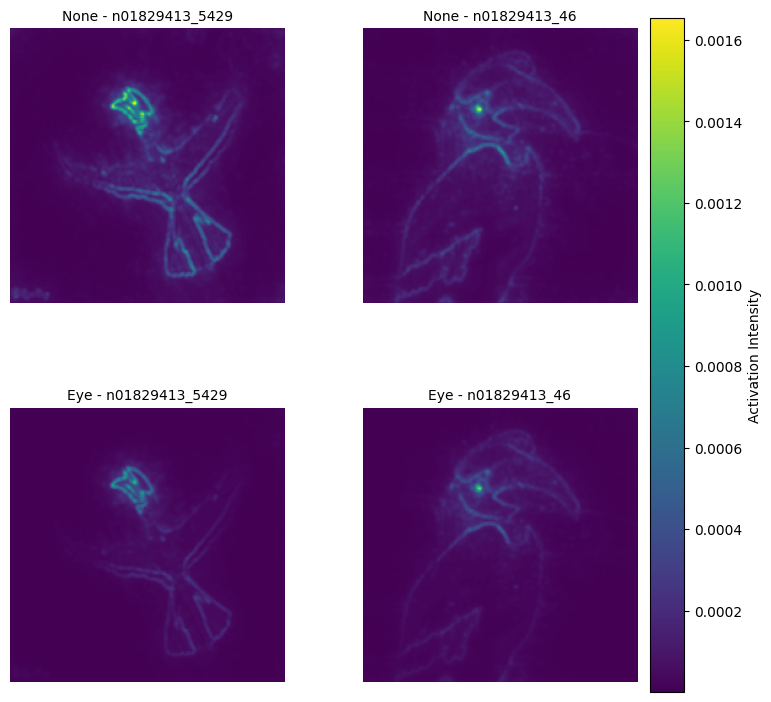

In [77]:
visualize_clusters(cluster_analysis_file_to_use, base_path, target_occurence_min_per_class, list_image_name_to_test)